Final model with 5 folds, all the features and chosen hyperparameters

In [6]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = pd.read_csv('data/optimized_data.csv')
target_df = pd.read_csv('feature_engineered.csv')
y = target_df['ClaimNb']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = X.to_numpy()
y = y.to_numpy()

r2_scores = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestRegressor(n_estimators=100, min_samples_leaf=12, max_depth=8, random_state=42)
    model.fit(X_train, y_train)

    y_hat = model.predict(X_test)

    print(f'R2 score: {r2_score(y_test, y_hat)}')
    r2_scores.append(r2_score(y_test, y_hat))

print(f'Average R2 score: {np.mean(r2_scores)}')


c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


R2 score: 0.04134382104327983
R2 score: 0.03577282648815028
R2 score: 0.0402469466979527
R2 score: 0.0371617772140137
R2 score: 0.03274860913568867
Average R2 score: 0.037454796115817035


Hyperparameters selection based on r2 score


 BEST HYPERPARAMETERS FOUND
max_depth = 11
min_leaves = 12
CV R²  = 0.03239


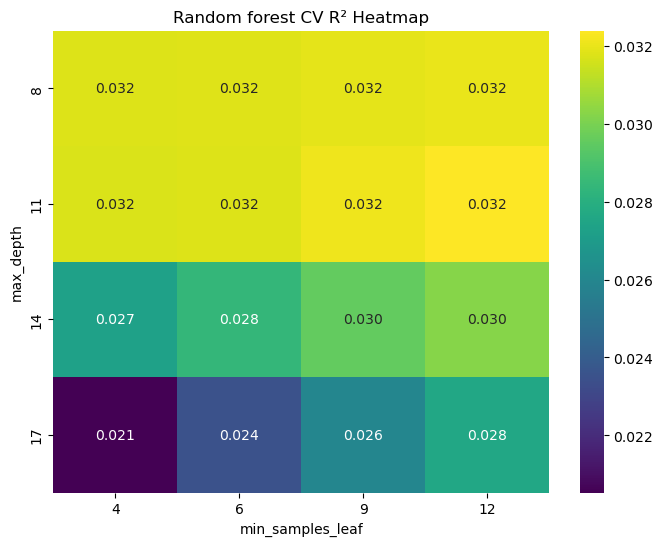

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('feature_engineered.csv')

X = df[['Density', 'DrivAge', 'Exposure', 'VehAge','VehPower', 'BonusMalus', 'VehGas']]
X = pd.get_dummies(X, drop_first=True)
y = df['ClaimNb']

X = X.to_numpy()
y = y.to_numpy()

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# hyperparameters
max_depth_values = [8, 11, 14, 17]
min_leaf_values = [4,6,9, 12]
results = []

# heatmap for plotting
r2_matrix = np.zeros((len(max_depth_values), len(min_leaf_values)))

# cross validation for each hyperparameter combination
for i, d in enumerate(max_depth_values):
    for j, l in enumerate(min_leaf_values):
        r2_scores = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = RandomForestRegressor(n_estimators=50,random_state=42, max_depth=d, min_samples_leaf=l, n_jobs=-1)
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)

            r2_scores.append(r2_score(y_test, y_hat))

        avg_r2 = np.mean(r2_scores)
        results.append(((d, l), avg_r2))
        r2_matrix[i, j] = avg_r2

# getting the best result from stored R2 values
best_config = max(results, key=lambda x: x[1])
(best_d, best_l), best_r2 = best_config
print(f"max_depth = {best_d}")
print(f"min_leaves = {best_l}")
print(f"CV R2  = {best_r2:.5f}")
plt.figure(figsize=(8, 6))
sns.heatmap(r2_matrix, annot=True, fmt=".3f",
            xticklabels=min_leaf_values,
            yticklabels=max_depth_values,
            cmap="viridis")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.title("Random forest CV R2 Heatmap")
plt.show()

Model made to export its predictions for further inspection

In [7]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


X = pd.read_csv('data/optimized_data.csv')
target_df = pd.read_csv('feature_engineered.csv')
y = target_df['ClaimNb']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

model = RandomForestRegressor(n_estimators=300, min_samples_leaf=12, max_depth=8, random_state=42)
model.fit(x_train, y_train)

y_hat = model.predict(x_test)

print(f'R2 score: {r2_score(y_test, y_hat)}')

claims_df = pd.DataFrame(data={'claims_true': y_test, 'claims_predicted': y_hat})
claims_df.to_csv('RF_predictions.csv')

R2 score: 0.03542445407000472


In [8]:
import pandas as pd
dataframe = pd.read_csv('RF_predictions.csv')
dataframe

,Unnamed: 0,claims_true,claims_predicted
0,390433,0,0.060344
1,307966,0,0.063747
2,352616,1,0.147859
3,73461,0,0.056181
4,134345,0,0.021833
...,...,...,...
135349,300776,1,0.126665
135350,38023,1,0.073389
135351,130070,0,0.064816
135352,487816,0,0.016261


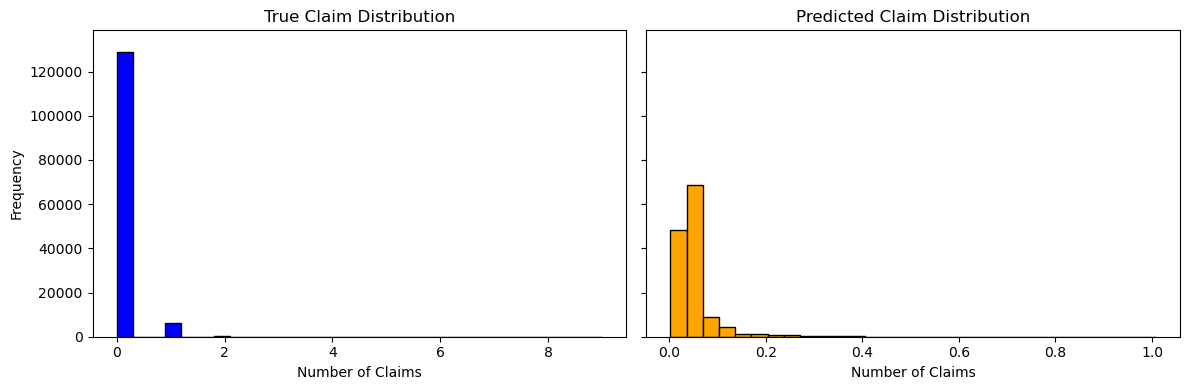

In [9]:
import matplotlib.pyplot as plt
import numpy as np

y_true = dataframe['claims_true']
y_pred = dataframe['claims_predicted']

bins = 30

# Compute histogram counts first (without plotting)
counts_true, _ = np.histogram(y_true, bins=bins)
counts_pred, _ = np.histogram(y_pred, bins=bins)

# Shared y-axis limit
y_max = max(counts_true.max(), counts_pred.max()) + 10000

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# True values
axes[0].hist(y_true, bins=bins, color='blue', edgecolor='black')
axes[0].set_ylim(0, y_max)
axes[0].set_xlabel('Number of Claims')
axes[0].set_ylabel('Frequency')
axes[0].set_title('True Claim Distribution')

# Predicted values
axes[1].hist(y_pred, bins=bins, color='orange', edgecolor='black')
axes[1].set_ylim(0, y_max)
axes[1].set_xlabel('Number of Claims')
axes[1].set_title('Predicted Claim Distribution')

plt.tight_layout()
plt.show()


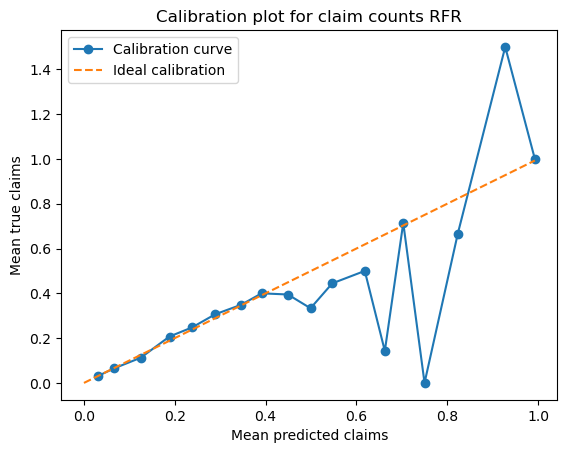

In [10]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, y_pred.max(), 20)
bin_ids = np.digitize(y_pred, bins)

mean_pred = []
mean_true = []

for b in range(1, len(bins)):
    idx = bin_ids == b
    if np.any(idx):
        mean_pred.append(y_pred[idx].mean())
        mean_true.append(y_true[idx].mean())

plt.plot(mean_pred, mean_true, marker='o', label='Calibration curve')
plt.plot([0, max(mean_pred)], [0, max(mean_pred)], linestyle='--', label='Ideal calibration')
plt.xlabel("Mean predicted claims")
plt.ylabel("Mean true claims")
plt.title("Calibration plot for claim counts RFR")
plt.legend()
plt.show()


Check the same configurations of hyperparameters as we used for M1 decision tree for overfitting.

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = pd.read_csv('data/optimized_data.csv')
target_df = pd.read_csv('feature_engineered.csv')
y = target_df['ClaimNb']

# Train / Validation only
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

clf = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=12, max_depth=8)
clf.fit(X_train, y_train)


# Evaluate
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

print("--------------- TRAIN SET ---------------")
print("MSE:", mean_squared_error(y_train, y_pred_train))
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")

print("\n--------------- VALIDATION SET ---------------")
print("MSE:", mean_squared_error(y_val, y_pred_val))
print(f"R² Score: {r2_score(y_val, y_pred_val):.4f}")


--------------- TRAIN SET ---------------
MSE: 0.054306644375603556
R² Score: 0.0475

--------------- VALIDATION SET ---------------
MSE: 0.05510025277017427
R² Score: 0.0353


Doing the cross-validation for hyperparameters again, but this time check the error for both training and validation split so we avoid overfitting and guarantee stable results

c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\misog\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\misog\anaconda3\Lib\s

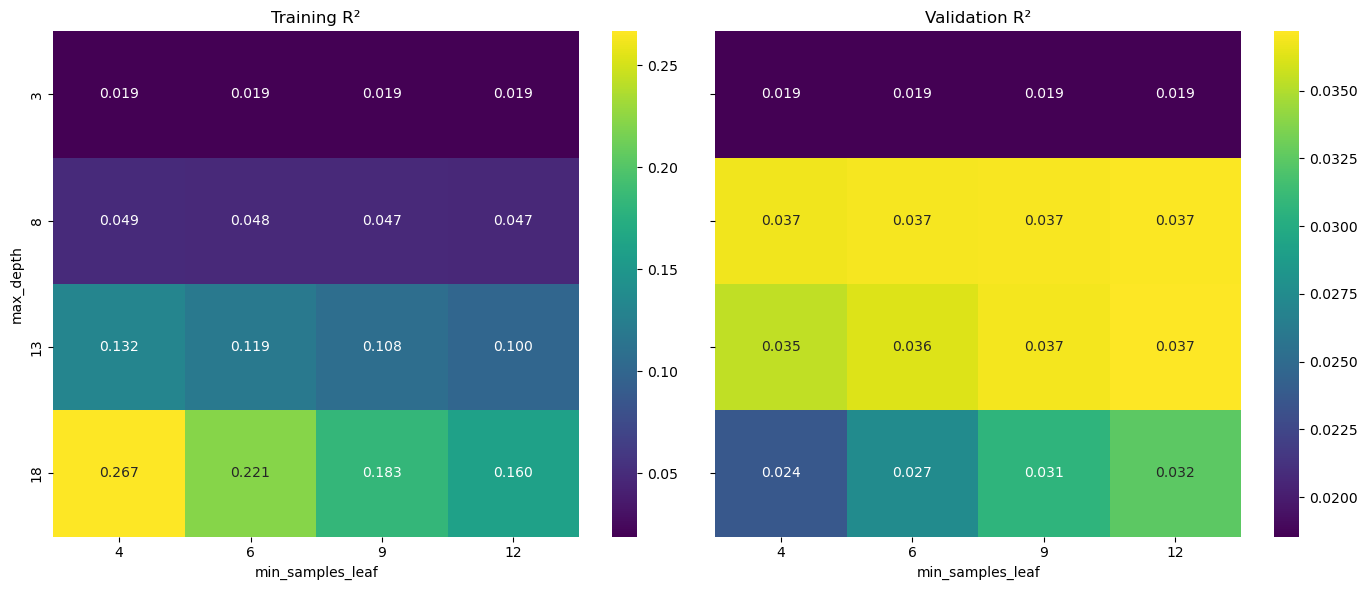

In [13]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


X = pd.read_csv('data/optimized_data.csv')
target_df = pd.read_csv('feature_engineered.csv')
y = target_df['ClaimNb']

X = X.to_numpy()
y = y.to_numpy()

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# hyperparameters
max_depth_values = [3, 8, 13, 18]
min_leaf_values = [4,6,9, 12]
results = []

train_matrix = np.zeros((len(max_depth_values), len(min_leaf_values)))
val_matrix = np.zeros((len(max_depth_values), len(min_leaf_values)))

# cross validation for each hyperparameter combination
for i, d in enumerate(max_depth_values):
    for j, l in enumerate(min_leaf_values):
        r2_scores_train = []
        r2_scores_val = []

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = RandomForestRegressor(n_estimators=50,random_state=42, max_depth=d, min_samples_leaf=l, n_jobs=-1)
            model.fit(X_train, y_train)
            y_hat_train = model.predict(X_train)
            y_hat_val = model.predict(X_val)
            
            r2_scores_train.append(r2_score(y_train, y_hat_train))
            r2_scores_val.append(r2_score(y_val, y_hat_val))

        train_matrix[i, j] = np.mean(r2_scores_train)
        val_matrix[i, j] = np.mean(r2_scores_val)
        

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#training R² heatmap
sns.heatmap(
    train_matrix,
    annot=True,
    fmt=".3f",
    xticklabels=min_leaf_values,
    yticklabels=max_depth_values,
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_title("Training R²")
axes[0].set_xlabel("min_samples_leaf")
axes[0].set_ylabel("max_depth")

#validation R² heatmap
sns.heatmap(
    val_matrix,
    annot=True,
    fmt=".3f",
    xticklabels=min_leaf_values,
    yticklabels=max_depth_values,
    cmap="viridis",
    ax=axes[1]
)
axes[1].set_title("Validation R²")
axes[1].set_xlabel("min_samples_leaf")

plt.tight_layout()
plt.show()


In [ ]:
# Load training data
training_data = pd.read_csv("data/final_train_data.csv")
X_train = training_data.drop("ClaimNb", axis=1)
y_train = training_data["ClaimNb"]

# Load test data (REAL unseen)
test_data = pd.read_csv("data/processed_test_data.csv")
X_test = test_data[['BonusMalus', 'Exposure', 'VehAge', 'VehBrand_B12', 'DrivAge', 'VehPower', 'VehGas_Regular', 'Density' ]]
y_test = test_data["ClaimNb"]


,BonusMalus,Exposure,VehAge,VehBrand_B12,DrivAge,VehPower,VehGas_Regular,Density
0,95,0.43,18,0,36,7,1,1054
1,95,0.10,17,0,80,7,1,598
2,76,0.33,3,0,36,7,1,4172
3,52,0.56,4,0,73,5,0,15
4,50,0.27,0,0,37,8,0,3021
...,...,...,...,...,...,...,...,...
541411,76,0.20,10,0,32,6,0,1314
541412,60,0.06,14,0,34,10,0,685
541413,95,0.34,8,0,32,6,0,242
541414,72,0.72,7,0,39,9,1,3301


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load training data
training_data = pd.read_csv("data/final_train_data.csv")
X_train = training_data.drop("ClaimNb", axis=1)
y_train = training_data["ClaimNb"]

# Load test data (REAL unseen)
test_data = pd.read_csv("data/processed_test_data.csv")
X_test = test_data[['BonusMalus', 'Exposure', 'VehAge', 'VehBrand_B12', 'DrivAge', 'VehPower', 'VehGas_Regular', 'Density' ]]
y_test = test_data["ClaimNb"]

# Train final model (hyperparameters already fixed)
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=12,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate on unseen test data
y_test_pred = model.predict(X_test)

print("Final TEST performance")
print(f"R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")

claims_df = pd.DataFrame(data={'claims_true': y_test, 'claims_predicted': y_test_pred})
claims_df.to_csv('RF_predictions.csv')



Final TEST performance
R²:  0.0386
MSE: 0.0579


In [24]:

import pandas as pd
dataframe = pd.read_csv('RF_predictions.csv')
dataframe

,Unnamed: 0,claims_true,claims_predicted
0,0,0,0.065648
1,1,0,0.035057
2,2,0,0.217027
3,3,0,0.018541
4,4,0,0.021375
...,...,...,...
135368,135368,0,0.044949
135369,135369,0,0.098144
135370,135370,0,0.056878
135371,135371,0,0.044298


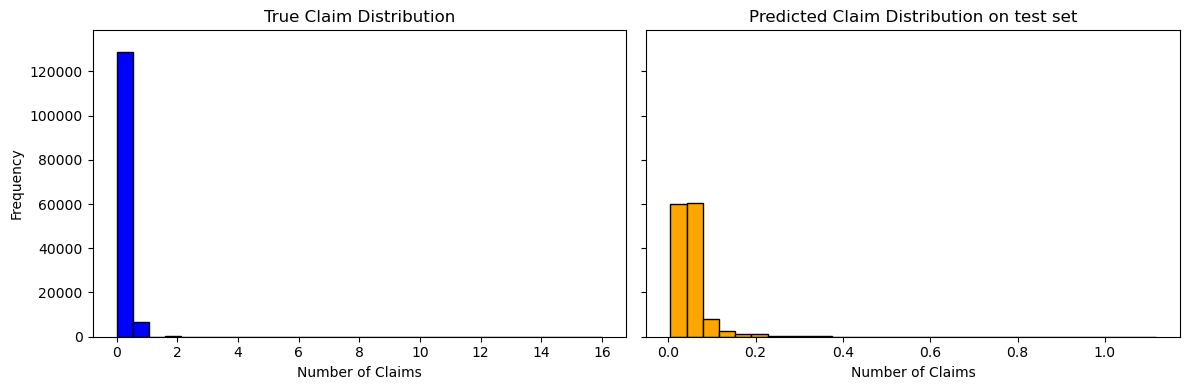

In [25]:
import matplotlib.pyplot as plt
import numpy as np

y_true = dataframe['claims_true']
y_pred = dataframe['claims_predicted']

bins = 30

# Compute histogram counts first (without plotting)
counts_true, _ = np.histogram(y_true, bins=bins)
counts_pred, _ = np.histogram(y_pred, bins=bins)

# Shared y-axis limit
y_max = max(counts_true.max(), counts_pred.max()) + 10000

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# True values
axes[0].hist(y_true, bins=bins, color='blue', edgecolor='black')
axes[0].set_ylim(0, y_max)
axes[0].set_xlabel('Number of Claims')
axes[0].set_ylabel('Frequency')
axes[0].set_title('True Claim Distribution')

# Predicted values
axes[1].hist(y_pred, bins=bins, color='orange', edgecolor='black')
axes[1].set_ylim(0, y_max)
axes[1].set_xlabel('Number of Claims')
axes[1].set_title('Predicted Claim Distribution on test set')

plt.tight_layout()
plt.show()
